**<font size=6>Applied Data Science Final Project: Examining Complaints of Syringe Litter in NYC</font>**

Amanda Bretti

# 1 Problem Statement

## <font size="4">1.1 Describe the project problem statement.</font>

New York City has over one hundred drop-off sites for the safe disposal of medical sharps. In spite of this, many parks are littered with used needles and syringes (Lunsford, 2025), which residents can report through the city's 311 system. In this project, I aim to investigate the factors that contribute to syringe-related complaints in New York City.



## <font size="4">1.2 How will the problem be tackled and solved?</font>

My approach involves analyzing 311 complaints, sharps drop-off site availability, and census data for neighborhoods across NYC. I will analyze  temporal trends in syringe-related complaints, as well as the geographic distribution of both complaints and drop-off sites. Additionally, I will examine the correlations between syringe complaints and other categories of 311 complaints. Finally, I will build a predictive model to identify key factors related to syringe complaints.

## <font size="4">1.3 What are the parameters around your problem statement to make it simple enough to solve but not trivial?</font>

To make this project more achievable, I will limit the scope to 311 complaints filed between 2022 and 2024. In addition, I will conduct much of my analysis at the neighborhood level. Specifically, I will group the 311 complaints by neighborhood tabulation area (NTA), a statistical geography that “roughly approximate[s] what New Yorkers think of as neighborhoods, or groupings of neighborhoods” (NYC Department of City Planning | Population Division, 2021). There are 262 NTAs, which is a manageable number to analyze.

## <font size="4">1.4 What is the core business or research problem you are solving? Why is it important?</font>

Syringe litter is a concern due to the risk of transmitting diseases such as Hepatitis C and HIV from needlestick injuries (U.S. Food & Drug Administration, 2021). In addition, syringes can clog equipment at sewage-treament sites (Commonwealth of Massachusetts, n.d.). By studying the factors contributing to syringe-related complaints, I hope to help identify gaps in the current disposal system and ways to assist residents in disposing of syringes more easily and safely.

# 2 Datasets

For my project, I will access four datasets from the NYC Open Data portal:
- 311 Service Requests from 2010 to Present
- Pharmaceutical and Syringe Drop-Off Locations in NYC
- 2020 Neighborhood Tabulation Areas (NTAs)
- Hotels Properties Citywide

The NYC Open Data API is powered by Socrata, allowing me to query the datasets using Socrata Query Language (SoQL). This is especially useful for accessing the 311 complaints data, which contains almost 40 million rows and would be difficult to download in its entirety.

In addition to the data from the NYC Open Data portal, I will also use three datasets from the American Community Survey, consisting of demographic, economic, and housing data for each neighborhood tabulation area. Syringe complaints may not be an accurate measure of the amount of syringe litter, but rather a measure of how bothered people are by it. For this reason, I'm particularly interested in features related to wealth inequality, such as unemployment rate and the percentage of renter-occupied housing units.

In [83]:
# Install libraries
!pip install geodatasets
!pip install pysal

# Import libraries
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import randint
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import geopandas as gpd
import geodatasets

In [2]:
# Download all of the 311 complaints in 2022, 2023, and 2024
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, incident_address, incident_zip, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')
all_311_complaints.head(2)

<ipython-input-2-1d33e6c318ff>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')


,unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude
0,53696273,2022-03-20T13:53:03.000,Blocked Driveway,No Access,37-44 108 STREET,11368.0,-73.859915,40.752934
1,53695167,2022-03-19T15:09:58.000,Missed Collection,Bulky Trash,4604 FT HAMILTON PARKWAY,11219.0,-73.995647,40.639729


In [3]:
# Download the sharps drop-off site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [4]:
# Download neighborhood tabulation area (NTA) data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip -O nta.zip
!unzip nta.zip

--2025-05-09 21:29:23--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 184.50.178.47, 2600:1417:76:49b::1500, 2600:1417:76:49e::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|184.50.178.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989198 (966K) [application/zip]
Saving to: ‘nta.zip’

nta.zip             100%[===================>] 966.01K  --.-KB/s    in 0.02s   

2025-05-09 21:29:26 (43.5 MB/s) - ‘nta.zip’ saved [989198/989198]

Archive:  nta.zip
  inflating: nynta2020_25a/nynta2020.shp  
  inflating: nynta2020_25a/nynta2020.dbf  
  inflating: nynta2020_25a/nynta2020.shx  
  inflating: nynta2020_25a/nynta2020.prj  
  inflating: nynta2020_25a/nynta2020.shp.xml  


In [5]:
# Load the NTA data
nta = gpd.read_file('/content/nynta2020_25a/nynta2020.shp').to_crs(2263)
nta.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."


In [6]:
# Load the hotel data
hotels = pd.read_csv('https://data.cityofnewyork.us/resource/tjus-cn27.csv?$limit=5000')
hotels.head(2)

,parid,borocode,block,lot,taxyear,street_num,street_name,postcode,bldg_class,taxclass,...,borough,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,nta_code2
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,...,MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,...,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN


In [7]:
# Download the American Community Survey data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip -O acs.zip
!unzip acs.zip

--2025-05-09 21:29:29--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 184.50.178.47, 2600:1417:76:49b::1500, 2600:1417:76:49e::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|184.50.178.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389208 (9.0M) [application/zip]
Saving to: ‘acs.zip’

acs.zip             100%[===================>]   8.95M  --.-KB/s    in 0.1s    

2025-05-09 21:29:32 (94.2 MB/s) - ‘acs.zip’ saved [9389208/9389208]

Archive:  acs.zip
   creating: 5-yr ACS 2022/CityCouncilDistrict/
   creating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/Dem_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Economic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Economic/Econ_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Housing/
  inflatin

In [8]:
# Load the ACS demographic data
acs_demographic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Demographic/Dem_1822_NTA.xlsx')
acs_demographic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,...,AsnOAsnE,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,38260,1664.0,2.6,100.0,0.0,...,9,13.0,87.8,0.5,0.7,143,114.0,48.5,7.5,5.8
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,64311,2670.0,2.5,100.0,0.0,...,30,43.0,87.1,0.6,0.8,190,137.0,43.9,3.6,2.5


In [9]:
# Load the ACS economic data
acs_economic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Economic/Econ_1822_NTA.xlsx')
acs_economic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop16plE,Pop16plM,Pop16plC,Pop16plP,Pop16plZ,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,33601,1431.0,2.6,100.0,0.0,...,4404,592.0,8.2,11.6,1.5,20096,1295.0,3.9,52.8,2.5
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,53760,2115.0,2.4,100.0,0.0,...,4381,656.0,9.1,6.8,1.0,29900,1629.0,3.3,46.6,1.6


In [10]:
# Load the ACS housing data for NTAs
acs_housing = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Housing/Hous_1822_NTA.xlsx')
acs_housing.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,HU1E,HU1M,HU1C,HU1P,HU1Z,...,GRPI50plE,GRPI50plM,GRPI50plC,GRPI50plP,GRPI50plZ,GRPINtCE,GRPINtCM,GRPINtCC,GRPINtCP,GRPINtCZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,19564,652.0,2.0,100.0,0.0,...,2434,444.0,11.1,17.1,3.0,548,172.0,19.1,NaN,NaN
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,30539,938.0,1.9,100.0,0.0,...,4547,526.0,7.0,19.9,2.1,616,193.0,19.1,NaN,NaN


# 3 Data Cleaning

## 311 complaints

In [11]:
# Look at the size of all_311_complaints
all_311_complaints.shape

(9853715, 8)

In [12]:
# Look at the data types
all_311_complaints.dtypes

,0
unique_key,int64
created_date,object
complaint_type,object
descriptor,object
incident_address,object
incident_zip,object
longitude,float64
latitude,float64


In [13]:
# Convert created_date to datetime
all_311_complaints['created_date'] = pd.to_datetime(all_311_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month
all_311_complaints['created_year'] = all_311_complaints['created_datetime'].dt.year

In [14]:
# Look at missing values
all_311_complaints.isna().sum()

,0
unique_key,0
created_datetime,0
complaint_type,0
descriptor,308002
incident_address,400293
incident_zip,117370
longitude,153307
latitude,153307
created_date,0
created_month,0


Many of the 311 complaints are missing latitude and longitude data, which I need for much of my analysis. However, I will keep these complaints in the dataset for now, as they are still useful for analyzing temporal trends.

In [15]:
# Look at columns 2-9, which will be used to check for duplicates
all_311_complaints.columns[2:9]

Index(['complaint_type', 'descriptor', 'incident_address', 'incident_zip',
       'longitude', 'latitude', 'created_date'],
      dtype='object')

In [16]:
# Look at duplicate complaints
(all_311_complaints[all_311_complaints.duplicated(subset = all_311_complaints.columns[2:9], keep = False)]
 .sort_values(by = ['created_date', 'complaint_type', 'descriptor', 'latitude', 'longitude']))

,unique_key,created_datetime,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude,created_date,created_month,created_year
173423,52940163,2022-01-01 22:43:26,APPLIANCE,ELECTRIC/GAS RANGE,102 SUFFOLK STREET,10002.0,-73.986219,40.718696,2022-01-01,1,2022
176298,52940833,2022-01-01 22:52:27,APPLIANCE,ELECTRIC/GAS RANGE,102 SUFFOLK STREET,10002.0,-73.986219,40.718696,2022-01-01,1,2022
173417,52942394,2022-01-01 10:48:04,Abandoned Vehicle,With License Plate,109-01 MONTEREY STREET,11429.0,-73.739217,40.709143,2022-01-01,1,2022
176889,52943087,2022-01-01 10:49:53,Abandoned Vehicle,With License Plate,109-01 MONTEREY STREET,11429.0,-73.739217,40.709143,2022-01-01,1,2022
169051,52938976,2022-01-01 14:08:38,Abandoned Vehicle,With License Plate,540 AUDUBON AVENUE,10040.0,-73.927203,40.855776,2022-01-01,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
7674974,63585445,2024-12-31 16:05:00,Water System,Possible Water Main Break (Use Comments) (WA1),NaN,11230.0,-73.969967,40.609151,2024-12-31,12,2024
7669268,63573334,2024-12-31 09:11:00,Water System,Possible Water Main Break (Use Comments) (WA1),1212 EAST 58 STREET,11234.0,-73.919814,40.625066,2024-12-31,12,2024
7764967,63578458,2024-12-31 03:26:00,Water System,Possible Water Main Break (Use Comments) (WA1),1212 EAST 58 STREET,11234.0,-73.919814,40.625066,2024-12-31,12,2024
7673271,63573335,2024-12-31 16:41:00,Water System,Possible Water Main Break (Use Comments) (WA1),NaN,11367.0,-73.817172,40.727271,2024-12-31,12,2024


This is not an ideal method for filtering duplicate complaints. First of all, it doesn't distinguish between true duplicates and separate incidents that share the same date, category, and location. Furthermore, some complaints lack location data, so any with the same date and category will be marked as duplicates. Before continuing, I will check how many complaints are missing location information.

In [17]:
# Check how many complaints have no location information
len(all_311_complaints[pd.isna(all_311_complaints['incident_address']) &
                       pd.isna(all_311_complaints['incident_zip']) &
                       pd.isna(all_311_complaints['latitude']) &
                       pd.isna(all_311_complaints['longitude'])])

46004

In [18]:
# Check how many syringe complaints have no location information
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].isna().sum()

,0
unique_key,0
created_datetime,0
complaint_type,0
descriptor,0
incident_address,1
incident_zip,1
longitude,61
latitude,61
created_date,0
created_month,0


Only 46,005 complaints, or about 0.5% of the total, are missing location data, and only one of the syringe complaints is missing location data. Since this is such a small subset of the data, I don't expect it to significantly affect my analysis. Therefore, I will go ahead with removing the duplicates.

In [19]:
# Remove duplicate complaints
all_311_complaints = all_311_complaints.drop_duplicates(subset = all_311_complaints.columns[2:9])
all_311_complaints.reset_index(drop = True, inplace = True)

In [20]:
# Look at the new size of all_311_complaints
all_311_complaints.shape

(8286146, 11)

Next, I will convert all_311_complaints to a GeoDataFrame, with the geometry column in the NAD83 / New York Long Island (ftUS) coordinate reference system.
This conversion will allow me to perform a spatial join later, in order to link each 311 complaint to a neighborhood tabulation area. Using the NAD83 coordinate reference system will also be useful for measuring distances to sharps drop-off sites and other locations.

In [21]:
# Convert all_311_complaints into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
all_311_complaints = gpd.GeoDataFrame(all_311_complaints,
                                      geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude),
                                      crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(2263)

In [22]:
all_311_complaints.head(2)

,unique_key,created_datetime,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude,created_date,created_month,created_year,geometry
0,53696273,2022-03-20 13:53:03,Blocked Driveway,No Access,37-44 108 STREET,11368.0,-73.859915,40.752934,2022-03-20,3,2022,POINT (1023062 213622.014)
1,53695167,2022-03-19 15:09:58,Missed Collection,Bulky Trash,4604 FT HAMILTON PARKWAY,11219.0,-73.995647,40.639729,2022-03-19,3,2022,POINT (985458 172347.014)


## Drop-off sites

In [23]:
# Check for missing values
dropoff_sites.isna().sum()

,0
borough,0
ntaname,0
site_type,0
sitename,0
zipcode,0
phonenum,153
days_hours,153
address,0
borocd,0
notes,153


In [24]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [25]:
# Look at the values in the 'days_hours' column
dropoff_sites['days_hours'].value_counts()

,count
days_hours,
24/7,26
Monday-Friday 9am-5pm,19
9am-5pm,14
Monday-Friday 8am-4pm,7
10am-4pm,4
...,...
Monday-Thursday 10am-3pm,1
Monday-Sunday 11am-1pm,1
"Monday, Tuesday, Friday 9am-5pm; Wednesday 10AM-5PM; Thursday 9AM-7PM",1


The "days_hours" column is extremely inconsistent, and cleaning it manually would be time-consuming. To solve this issue, I will use Gemini LLM to convert this column into a more quantifiable format. For each drop-off site, I'll ask Gemini to determine whether the listed hours are logically interpretable. This will ideally make it ignore ambiguous entries such as "Monday-Wednesday 9". Then, I'll ask Gemini to calculate the total hours the site is open in a 28-day month. To guide the LLM, I'll give it a specific output format and provide examples of correct responses.


In [26]:
# Use Google's Gemini LLM to parse the 'days_hours' column into something more quantifiable

# Import the necessary libraries
from IPython.display import HTML, Markdown, display
from google.colab import userdata
from google.api_core import retry
from google import genai
from pydantic import BaseModel

# Get my Google API key
GOOGLE_API_KEY = userdata.get('google_api_key')

# Handle errors
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate = is_retriable)(genai.models.Models.generate_content)

# Initialize the genAI client
client = genai.Client(api_key = GOOGLE_API_KEY)

# Define what the LLM's response should look like
class Response(BaseModel):
  logical: str
  hours_per_month: int

# For each dropoff site, ask whether the drop-off hours make sense
# If so, calculate the hours the site is open in a 28-day month
for i in range(len(dropoff_sites)):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''You are analyzing the opening hours of a drop-off site.
      For each set of opening hours, do the following:
      1. Determine if the description is logically interpretable.
      2. If so, estimate how many hours the site is open in a typical 28-day month.

      Respond in JSON with two fields:
      - "logical": "Yes" or "No"
      - "hours_per_month": integer (estimated total hours open in a 28-day month)

      Examples:
      Input: "24/7"
      Output: {{ "logical": "Yes", "hours_per_month": 672 }}

      Input: "Monday-Friday 8am-4pm"
      Output: {{ "logical": "Yes", "hours_per_month": 160 }}

      Input: "8"
      Output: {{ "logical": "No", "hours_per_month": 0 }}

      Now process these opening hours: {dropoff_sites.loc[i, 'days_hours']}.''',

      config={'response_mime_type': 'application/json',
              'response_schema': list[Response]})

  # Save the calculated hours
  if response.parsed[0].logical == 'Yes':
    dropoff_sites.loc[i, 'hours_per_month'] = response.parsed[0].hours_per_month
  else:
    dropoff_sites.loc[i, 'hours_per_month'] = np.nan

  # Track progress
  if i % 50 == 0:
    print(f'Progress: {i} rows')

Progress: 0 rows
Progress: 50 rows
Progress: 100 rows
Progress: 150 rows


In [27]:
# View the results
dropoff_sites[['days_hours', 'hours_per_month']]

,days_hours,hours_per_month
0,24/7,672.0
1,10am-2pm,112.0
2,9am-5pm,224.0
3,24/7,672.0
4,First and Last Friday of every month 2pm-4pm,4.0
...,...,...
188,Monday-Sunday 11am-1pm,56.0
189,"Monday, Tuesday, Friday 9am-5pm; Wednesday 10A...",128.0
190,Monday-Wednesday 9,NaN
191,Call for mobbile unit locations and hours,NaN


It looks like Gemini did a decent job at calculating the drop-off opening hours, although it still made some mistakes.

In [28]:
# Turn dropoff_sites into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
dropoff_sites = gpd.GeoDataFrame(dropoff_sites,
                                 geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude),
                                 crs = 'EPSG:4326')
dropoff_sites = dropoff_sites.to_crs(2263)

## Neighborhoods

In [29]:
# Look at the NTA dataset
nta.head()

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280306,1.520896e+07,"POLYGON ((998047.21 196303.325, 998157.901 196..."
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.799309,5.226741e+07,"POLYGON ((1005302.497 199455.73, 1005307.792 1..."
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.505244,9.982321e+06,"POLYGON ((986367.735 190549.239, 985813.835 19..."


I will replace the numbers in the column "NTAType" with categories, as defined in the dataset's metadata (NYC Department of City Planning, 2025). Since Rikers Island is the only neighborhood in category 5, I will group it with the neighborhoods in category 6, "Other Special Areas". These neighborhoods include Brooklyn Navy Yard and the United Nations.

In [30]:
# Look at the NTAs with NTAType = '5' or '6'
nta[nta['NTAType'].isin(['5', '6'])]

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
8,3,Brooklyn,047,BK0261,Brooklyn Navy Yard,BkNvyYrd,6,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,39415.643844,1.010681e+07,"MULTIPOLYGON (((990092.009 196467.097, 990091...."
33,3,Brooklyn,047,BK1061,Fort Hamilton,FtHmltn,6,BK10,BK10 Bay Ridge-Dyker Heights (CD 10 Approximat...,16460.955816,8.464624e+06,"POLYGON ((977370.418 161406.055, 977501.71 161..."
110,2,Bronx,005,BX1161,Hutchinson Metro Center,HtchMtrCtr,6,BX11,BX11 Pelham Parkway-Morris Park (CD 11 Approxi...,20669.438075,1.219015e+07,"POLYGON ((1030920.516 250980.183, 1030842.291 ..."
135,1,Manhattan,061,MN0661,United Nations,UN,6,MN06,MN06 East Midtown-Murray Hill (CD 6 Approximat...,5307.391555,1.091250e+06,"MULTIPOLYGON (((994166.305 211286.756, 994149...."
161,2,Bronx,005,QN0151,Rikers Island,RkrsIsl,5,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent),18897.487875,1.816373e+07,"POLYGON ((1019454.697 225654.329, 1019451.101 ..."
162,4,Queens,081,QN0161,Sunnyside Yards (North),SnnysdYd_N,6,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent),16111.611490,4.500282e+06,"POLYGON ((1009121.37 213619.074, 1009091.041 2..."
168,4,Queens,081,QN0261,Sunnyside Yards (South),SnnysdYd_S,6,QN02,QN02 Long Island City-Sunnyside-Woodside (CD 2...,22732.905457,8.783519e+06,"POLYGON ((1009266.586 212445.412, 1008736.256 ..."
192,4,Queens,081,QN0761,Fort Totten,FtTttn,6,QN07,QN07 Flushing-Murray Hill-Whitestone (CD 7 App...,14563.738400,6.957321e+06,"POLYGON ((1046807.67 225826.595, 1046337.968 2..."
258,5,Staten Island,085,SI9561,Fort Wadsworth,FtWdswrth,6,SI95,SI95 Great Kills Park-Fort Wadsworth (JIA 95 A...,14814.414469,9.867249e+06,"POLYGON ((967656.829 155637.131, 967549.629 15..."


In [31]:
# Replace NTAType integers with categories
nta['NTAType'] = nta['NTAType'].replace({'0': 'residential',
                            '5': 'other',
                            '6': 'other',
                            '7': 'cemetery',
                            '8': 'airport',
                            '9': 'park'})

I will also convert the NTA area from square feet to square miles, since that's a more commonly used measure of neighborhood size. However, the units shouldn't affect my analysis.

In [32]:
# Convert NTA area from square feet to square miles
nta['area_sq_mi'] = nta['Shape_Area'] / 2.788e+7

## American Community Survey

The American Community Survey datasets contain hundreds of columns, so I will select only those relevant to my analysis. These include:
- Pop_1E: the population estimate
- CvLFUEm1P: the percent of the labor force that is unemployed
- OChU6PLFP: the percent of families with children under 6 in which both parents work
- OC6t17PLFP: the percent of families with children between 6-17 in which both parents work
- MdHHIncE: the median household income
- PvU50P: the percent of the population with a ratio of income to poverty level < 0.5
- Pv500plP: the percent of the population with a ratio of income to poverty level > 5.00
- VacHUP: the percent of vacant housing units
- ROcHU1P: the percent of renter-occupied housing units (as opposed to owner-occupied)
- GRPI30plP: the percent of occupied units where rent is 30% or more of the household income

I will then merge each dataset with the neighborhood tabulation area dataset to consolidate all of the neighborhood data in a single DataFrame.

### Demographic data

In [33]:
# Rename 'GeoID' to 'NTA2020'
acs_demographic = acs_demographic.rename(columns = {'GeoID': 'NTA2020'})

In [34]:
# Get Pop_1E (population estimate) for each NTA
nta = nta.merge(acs_demographic[['NTA2020', 'Pop_1E']], on = 'NTA2020')

### Economic data

In [35]:
# Rename 'GeoID' to 'NTA2020'
acs_economic = acs_economic.rename(columns = {'GeoID': 'NTA2020'})

In [36]:
# Get the following variables for each NTA
# CvLFUEm1P: the percent of the labor force that is unemployed
# OChU6PLFP: the percent of families with children under 6 in which both parents work
# OC6t17PLFP: the percent of families with children between 6-17 in which both parents work
# MdHHIncE: the median household income
# PvU50P: the percent of the population with a ratio of income to poverty level < 0.5
# Pv500plP: the percent of the population with a ratio of income to poverty level > 5.00
nta = nta.merge(acs_economic[['NTA2020', 'CvLFUEm1P', 'OChU6PLFP', 'OC6t17PLFP', 'MdHHIncE', 'PvU50P', 'Pv500plP']], on = 'NTA2020')

### Housing data

In [37]:
# Rename 'GeoID' to 'NTA2020'
acs_housing = acs_housing.rename(columns = {'GeoID': 'NTA2020'})

In [38]:
# Get the following variables for each NTA
# VacHUP: the percent of vacant housing units
# ROcHU1P: the percent of renter-occupied housing units (as opposed to owner-occupied)
# GRPI30plP: the percent of occupied units where rent is 30% or more of the household income
nta = nta.merge(acs_housing[['NTA2020', 'VacHUP', 'ROcHU1P', 'GRPI30plP']])

In [39]:
# View nta again
nta.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,...,Pop_1E,CvLFUEm1P,OChU6PLFP,OC6t17PLFP,MdHHIncE,PvU50P,Pv500plP,VacHUP,ROcHU1P,GRPI30plP
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,residential,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,...,38260,5.8,84.1,78.1,125469.0,4.1,52.8,8.0,82.2,35.1
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,residential,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,...,64311,5.1,67.0,65.2,129838.0,7.1,46.6,7.4,83.1,42.0


## Hotels

In [40]:
# Check for missing values
hotels.isna().sum()

,0
parid,0
borocode,0
block,0
lot,0
taxyear,0
street_num,2
street_name,0
postcode,0
bldg_class,0
taxclass,0


In [41]:
# Look at the number of hotels
hotels.shape

(5000, 21)

In [42]:
# Check for duplicate hotels (hotels with same address and owner)
hotels.duplicated(subset = ['street_num', 'street_name', 'postcode', 'owner_name']).sum()

np.int64(3077)

In [43]:
# Drop duplicate hotels (hotels with same address and owner)
hotels = hotels.drop_duplicates(subset = ['street_num', 'street_name', 'postcode', 'owner_name'])
hotels = hotels.reset_index(drop = True)

In [44]:
# Keep only the relevant columns
hotels = hotels[['parid', 'latitude', 'longitude']]

# Keep only the rows with latitude and longitude data
hotels = hotels[(pd.isna(hotels['longitude']) == False) & (pd.isna(hotels['latitude']) == False)]

In [45]:
# Turn hotels into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
hotels = gpd.GeoDataFrame(hotels, geometry = gpd.points_from_xy(hotels['longitude'], hotels['latitude']), crs = 'EPSG:4326')
hotels = hotels.to_crs(epsg=2263)

# 4 Data Visualization

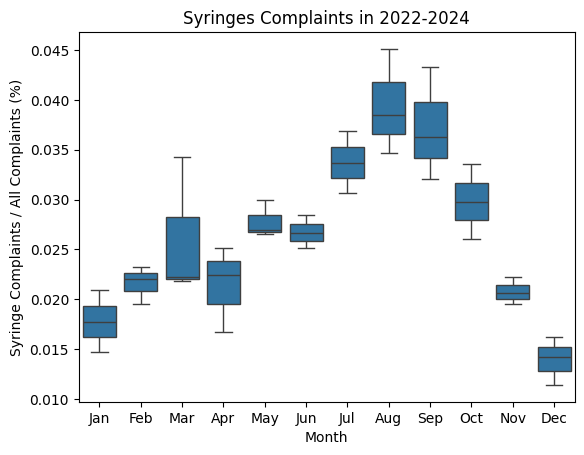

In [46]:
# Group the 311 complaints by month and year
# Count all of the complaints and the syringe-related complaints
complaints_by_month = all_311_complaints.groupby(['created_month', 'created_year']).agg(all_complaints = ('descriptor', 'count'),
                                                                                        syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()))

# Calculate syringe complaints as a percentage of total complaints
complaints_by_month['syringes/all (%)'] = 100 * complaints_by_month['syringe_complaints'] / complaints_by_month['all_complaints']

# Plot syringe complaints (%) by month
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax = sns.boxplot(data = complaints_by_month,
                 x = 'created_month',
                 y = 'syringes/all (%)',
                 order = order)
ax.set_xlabel('Month')
ax.set_ylabel('Syringe Complaints / All Complaints (%)')
plt.title('Syringes Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

The figure above shows that the proportion of syringe complaints follows a seasonal trend, peaking in summer and declining in winter. Several factors could explain this trend. First, people tend to spend less time outdoors in winter, which may lead to less syringe litter being generated, or simply fewer people noticing and reporting it. Additionally, snowfall could hide syringe litter, preventing people from noticing it. In the future, I would like to explore whether syringe complaints correlate with average monthly temperatures or snowfall.

In [47]:
# Load map of NYC for plotting, CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


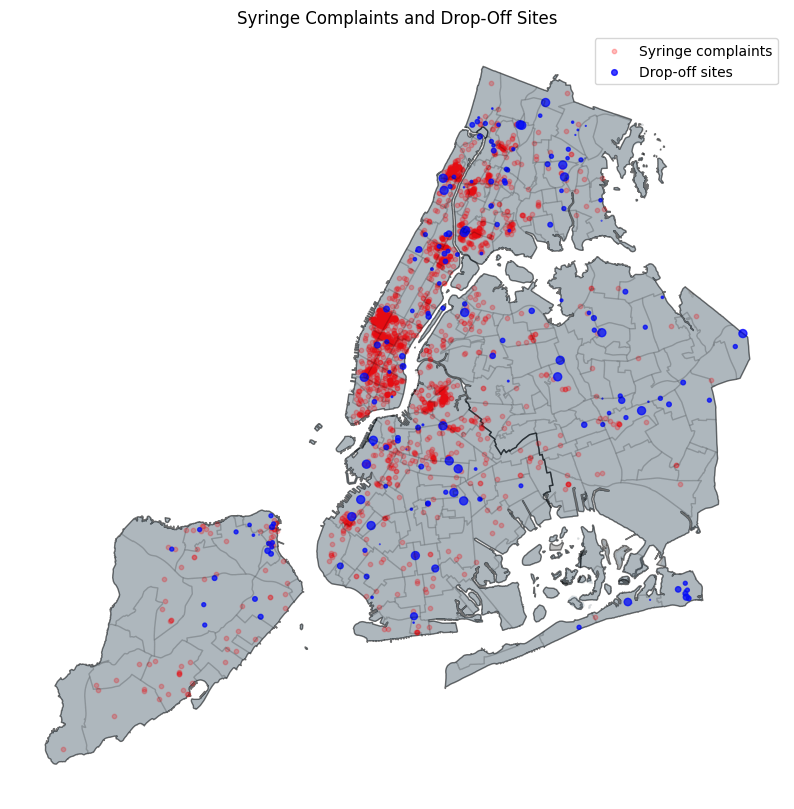

In [48]:
# Plot the syringe complaints, drop-off sites, and NTAs on a map of NYC
fig, ax = plt.subplots(figsize = (10, 10))

# Plot the map of NYC
nyc.plot(ax = ax, alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Plot the drop-off sites
# Size each marker based on the drop-off site availability
dropoff_sites.plot(ax = ax, markersize = dropoff_sites['hours_per_month']*0.05, alpha = 0.75, color = 'blue')

# Plot the NTAs
nta.plot(ax = ax, edgecolor = 'k', alpha = 0.1)

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe complaints', 'Drop-off sites'])
plt.title('Syringe Complaints and Drop-Off Sites')
plt.show()

The map above shows the distribution of syringe complaints and sharps drop-off sites across the city, with a large proportion of complaints in lower Manhattan. The size of the blue markers represents the availability of each drop-off site in hours per month. To better visualize this data, I will create a kernel density estimate (KDE) plot.

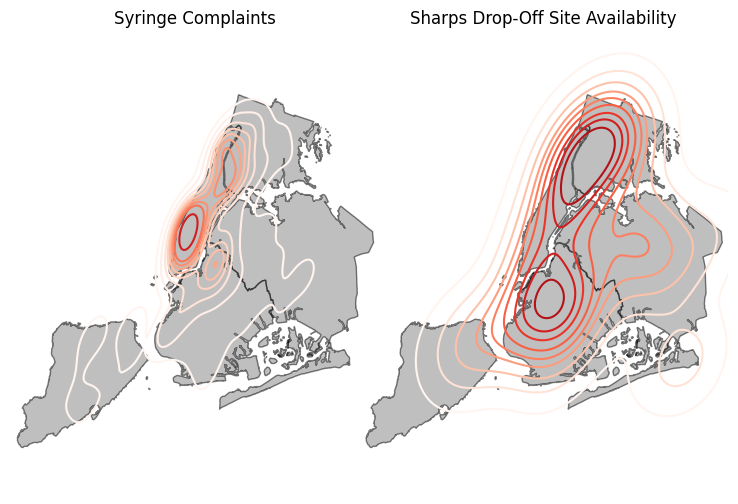

In [49]:
# Plot KDE plots of syringe complaints and drop-off sites side by side
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# Plot syringe complaints on one subplot
subplot1 = nyc.plot(ax = axes[0], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.x,
            y = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.y,
            cmap = 'Reds',
            ax=axes[0])

# Plot dropoff sites on the other subplot
# Weight the KDE using drop-off site availability (% of time open)
subplot2 = nyc.plot(ax = axes[1], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = dropoff_sites.geometry.x, y = dropoff_sites.geometry.y,
            weights = dropoff_sites['hours_per_month']/672,
            cmap = 'Reds',
            ax=axes[1])

# Format the plot
subplot1.set_axis_off()
subplot2.set_axis_off()

# Set x and y limits
axes[0].set_xlim(0.91e6, 1.07e6)
axes[0].set_ylim(100000, 300000)
axes[1].set_xlim(0.91e6, 1.07e6)
axes[1].set_ylim(100000, 300000)

# Title each subplot and adjust the spacing
axes[0].set_title('Syringe Complaints')
axes[1].set_title('Sharps Drop-Off Site Availability')
plt.subplots_adjust(wspace = -0.4)
plt.show()

The KDE plots above more clearly illustrate how the distribution of syringe complaints differs from that of available sharps drop-off sites. This implies that areas with a higher rate of syringe complaints could use more drop-off sites.

In [50]:
# Remove 311 complaints with no latitude and longitude data
all_311_complaints = all_311_complaints.dropna(subset = ['latitude', 'longitude'])
all_311_complaints.reset_index(drop = True, inplace = True)

In [51]:
# Do a spatial join to find the NTA associated with each 311 complaint
all_311_complaints = all_311_complaints.sjoin(nta[['NTA2020', 'geometry']], how = 'left')

I want to explore which other categories of 311 complaints are correlated with syringe complaints. To do this, I will group the complaints by neighborhood and calculate the correlation between the proportion of syringe complaints and the proportion of other types of complaints.

In [52]:
# Group the complaints by NTA
# Count all of the complaints and the syringe-related complaints
all = all_311_complaints.groupby('NTA2020').agg(all = ('unique_key', 'count')).sort_values(by = 'NTA2020').values
syringes = all_311_complaints.groupby('NTA2020').agg(syringes = ('descriptor', lambda x: (x == 'Syringes').sum())).sort_values(by = 'NTA2020').values

# Loop through each complaint type
for complaint in list(set(all_311_complaints['complaint_type'])):

  # Count the number of complaints for this complaint type
  other = all_311_complaints.groupby('NTA2020').agg(other = ('complaint_type', lambda x: (x == complaint).sum())).sort_values(by = 'NTA2020').values

  # Calculate the  correlation between the proportion of syringe complaints and the proportion of this other complaint type
  test_corr = stats.pearsonr(syringes/all, other/all)

  # If the correlation coefficient is greater than 0.4 and the p-value less than 0.05, print the complaint type
  if (abs(test_corr[0]) > 0.4) & (test_corr[1] < 0.05):
    print(complaint, test_corr)

Squeegee PearsonRResult(statistic=array([0.50485339]), pvalue=array([2.37570372e-18]))
Encampment PearsonRResult(statistic=array([0.45188317]), pvalue=array([1.37213591e-14]))
Homeless Person Assistance PearsonRResult(statistic=array([0.42973475]), pvalue=array([3.36519009e-13]))
Panhandling PearsonRResult(statistic=array([0.50133213]), pvalue=array([4.43165393e-18]))


Above, I have printed the complaint categories with a correlation coefficient less than -0.4 or greater than 0.4 and with a p-value less than 0.05. These categories are "Homeless Person Assistance", "Panhandling", "Encampment", and "Squeegee". According to the NYC 311 website, squeegee complaints refer to "people requesting money for unwanted car window washing" (City of New York, n.d.). It makes sense that this category is correlated with syringe complaints, as it is related to panhandling which is also correlated with syringe complaints.

Next, I will visualize the correlations between these complaint categories using a heatmap.

In [53]:
# Group all_311_complaints by NTA and count the following:
# All complaints
# Syringe complaints
# Encampment complaints
# Homeless Person Assistance complaints
# Panhandling complaints
# Squeegee complaints
complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                              syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                              encampment_complaints = ('complaint_type', lambda x: (x == 'Encampment').sum()),
                                                              homeless_assistance_complaints = ('complaint_type', lambda x: (x == 'Homeless Person Assistance').sum()),
                                                              panhandling_complaints = ('complaint_type', lambda x: (x == 'Panhandling').sum()),
                                                              squeegee_complaints = ('complaint_type', lambda x: (x == 'Squeegee').sum()))
complaints_by_nta.reset_index(inplace = True)

In [54]:
# Divide each category by all_complaints
complaints_by_nta['syringes/all (%)'] = 100 * complaints_by_nta['syringe_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['encampments/all (%)'] = 100 * complaints_by_nta['encampment_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['homeless assistance/all (%)'] = 100 * complaints_by_nta['homeless_assistance_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['panhandling/all (%)'] = 100 * complaints_by_nta['panhandling_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['squeegee/all (%)'] = 100 * complaints_by_nta['squeegee_complaints'] / complaints_by_nta['all_complaints']

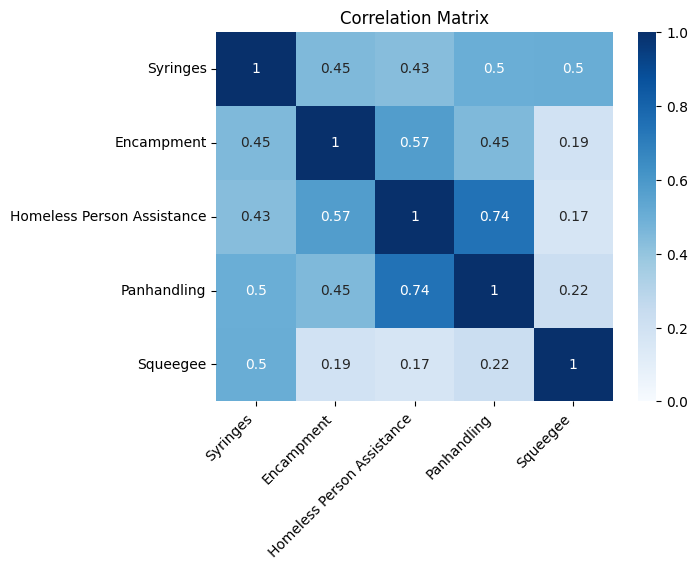

In [55]:
# Plot the correlation matrix between the proportion of syringe complaints and the proportion of the other complaint categories
fig, ax = plt.subplots()
sns.heatmap(complaints_by_nta[['syringes/all (%)',
                               'encampments/all (%)',
                               'homeless assistance/all (%)',
                               'panhandling/all (%)',
                               'squeegee/all (%)']].corr(),
            cmap = 'Blues', annot = True, vmin = 0, vmax = 1)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(['Syringes', 'Encampment', 'Homeless Person Assistance', 'Panhandling', 'Squeegee'], rotation = 45, ha = 'right')
ax.set_yticklabels(['Syringes', 'Encampment', 'Homeless Person Assistance', 'Panhandling', 'Squeegee'])
plt.show()

The heatmap above shows that many of the complaint categories are correlated with one another. Therefore, I will implement regularization during the model-building step to prevent overfitting.

# 5 Model Building

## 5.1 Feature Engineering

Before building a model, I will add several more features to the dataset. First, I will create columns for borough and NTA type.

In [56]:
# Convert "BoroName" into dummy variables
nta[['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']] = pd.get_dummies(nta['BoroName'], dtype = 'int64')

In [57]:
# Convert "NTAType" into dummy variables
nta[['airport', 'cemetery', 'other', 'park', 'residential']] = pd.get_dummies(nta['NTAType'], dtype = 'int64')

In [58]:
# Merge complaints_by_nta with nta
complaints_by_nta = complaints_by_nta.merge(nta[['NTA2020', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
                                                 'area_sq_mi', 'Pop_1E', 'CvLFUEm1P', 'OChU6PLFP', 'OC6t17PLFP', 'MdHHIncE',
                                                 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'airport',
                                                 'cemetery', 'park', 'residential', 'other']], on = 'NTA2020')

Next, I'll create several features that measure the distance to sharps drop-off sites and to Times Square. I included Times Square as a reference point to investigate whether syringe complaints might be correlated with tourism, give its status as a popular tourist destination.

To assign each neighborhood tabulation area an average distance to a drop-off site, I will generate 100 random points within each NTA and calculate the distance from each point to the nearest drop-off site. I will then calculate the average of those distances. Moreover, since some of the drop-off sites have limited hours, I will repeat the calculation using only those open at least 336 hours per 28-day month (at least 50% of the time).

In [59]:
# For each NTA, generate 100 random points
nta_random_points = gpd.GeoDataFrame()
nta_random_points['NTA2020'] = nta['NTA2020']
nta_random_points['random_points'] = nta['geometry'].sample_points(100, method='uniform', rng = 212)
nta_random_points = nta_random_points.set_index('NTA2020')
nta_random_points = nta_random_points['random_points'].explode(ignore_index = False).reset_index()

In [60]:
# For each random point, calculate the distance to the nearest drop-off site
nta_random_points['nearest_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites.distance(x).min()).round(0)
nta_random_points['nearest_dropoff_dist_mi'] = nta_random_points['nearest_dropoff_dist_ft'] / 5280

# For each random point, calculate the distance to the nearest drop-off site,
# but only include drop-off sites open at least 336 hours per month
dropoff_sites_336h = dropoff_sites[dropoff_sites['hours_per_month'] >= 336]
nta_random_points['nearest_available_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites_336h.distance(x).min()).round(0)
nta_random_points['nearest_available_dropoff_dist_mi'] = nta_random_points['nearest_available_dropoff_dist_ft'] / 5280

# For each random point, calculate the distance to Times Square
times_square = pd.DataFrame({'longitude': [-73.985130], 'latitude': [40.758896]})
times_square = gpd.points_from_xy(times_square.longitude, times_square.latitude, crs = 'EPSG:4326').to_crs(epsg=2263)
nta_random_points['times_square_dist_ft'] = nta_random_points['random_points'].apply(lambda x: times_square.distance(x).mean()).round(0)
nta_random_points['times_square_dist_mi'] = nta_random_points['times_square_dist_ft'] / 5280

# Group nta_random_points by NTA and calculate the average
nta_random_points = nta_random_points.groupby('NTA2020').agg(nearest_dropoff_dist_mi = ('nearest_dropoff_dist_mi', 'mean'),
                                                             nearest_available_dropoff_dist_mi = ('nearest_available_dropoff_dist_mi', 'mean'),
                                                             times_square_dist_mi = ('times_square_dist_mi', 'mean')).reset_index()

In [61]:
# Merge complaints_by_nta with nta_random_points
complaints_by_nta = complaints_by_nta.merge(nta_random_points[['NTA2020', 'nearest_dropoff_dist_mi',
                                                               'nearest_available_dropoff_dist_mi', 'times_square_dist_mi']],
                                            on = 'NTA2020')

Another measure of tourism is the number of hotels in an area. I'll calculate the number of hotels per NTA.

In [62]:
# Join hotels with nta and then group by NTA2020 to find the number of hotels in each NTA
hotels = gpd.sjoin(hotels, nta[['NTA2020', 'geometry', 'area_sq_mi']], how = 'left')
hotels_by_nta = hotels.groupby('NTA2020').agg(hotel_count = ('parid', 'count'),
                                           nta_area = ('area_sq_mi', 'mean')).reset_index()

In [63]:
# Calculate the hotels per square mile
hotels_by_nta['hotels_per_sq_mi'] = hotels_by_nta['hotel_count'] / hotels_by_nta['nta_area']

In [64]:
# Merge complaints_by_nta with hotels_by_nta
complaints_by_nta = complaints_by_nta.merge(hotels_by_nta[['NTA2020', 'hotels_per_sq_mi']], how = 'left', on = 'NTA2020')

In [84]:
# Visualize the correlation matrix
complaints_by_nta[complaints_by_nta.columns[1:]].corr()

,all_complaints,syringe_complaints,encampment_complaints,homeless_assistance_complaints,panhandling_complaints,squeegee_complaints,syringes/all (%),encampments/all (%),homeless assistance/all (%),panhandling/all (%),...,GRPI30plP,airport,cemetery,park,residential,other,nearest_dropoff_dist_mi,nearest_available_dropoff_dist_mi,times_square_dist_mi,hotels_per_sq_mi
all_complaints,1.000000,0.430547,0.410447,0.373506,0.438819,0.174266,0.250303,0.007900,0.135577,0.230780,...,0.541814,-0.092899,-0.290352,-0.506017,0.687342,-0.227759,-0.295657,-0.288173,-0.332603,0.190300
syringe_complaints,0.430547,1.000000,0.715380,0.563180,0.645177,0.600982,0.825672,0.340780,0.417651,0.510763,...,0.117001,-0.034159,-0.092537,-0.162191,0.220676,-0.072427,-0.166852,-0.165986,-0.382661,0.329950
encampment_complaints,0.410447,0.715380,1.000000,0.805241,0.781173,0.410137,0.623165,0.583652,0.715528,0.689096,...,0.083988,-0.037820,-0.104513,-0.177012,0.242977,-0.079505,-0.213798,-0.234437,-0.518890,0.540636
homeless_assistance_complaints,0.373506,0.563180,0.805241,1.000000,0.909004,0.232822,0.445820,0.418050,0.819639,0.727283,...,0.054829,-0.032053,-0.090214,-0.151882,0.208699,-0.068257,-0.173289,-0.194981,-0.447159,0.785660
panhandling_complaints,0.438819,0.645177,0.781173,0.909004,1.000000,0.303232,0.530211,0.385875,0.715562,0.854843,...,0.115444,-0.038864,-0.109055,-0.188990,0.257758,-0.084795,-0.181150,-0.193972,-0.460208,0.668671
squeegee_complaints,0.174266,0.600982,0.410137,0.232822,0.303232,1.000000,0.494623,0.190221,0.168552,0.224930,...,0.056876,-0.012273,-0.033249,-0.059400,0.080382,-0.026393,-0.081863,-0.079334,-0.189117,0.075943
syringes/all (%),0.250303,0.825672,0.623165,0.445820,0.530211,0.494623,1.000000,0.451883,0.429735,0.501332,...,0.045453,-0.042314,-0.114629,-0.095230,0.160965,-0.031885,-0.192969,-0.153094,-0.389184,0.263554
encampments/all (%),0.007900,0.340780,0.583652,0.418050,0.385875,0.190221,0.451883,1.000000,0.574366,0.452394,...,-0.172690,-0.036488,0.114479,0.004439,-0.059754,0.009010,-0.163026,-0.212813,-0.435245,0.291340
homeless assistance/all (%),0.135577,0.417651,0.715528,0.819639,0.715562,0.168552,0.429735,0.574366,1.000000,0.742842,...,-0.112521,-0.036294,-0.036766,-0.059461,0.046325,0.070310,-0.193852,-0.231619,-0.548541,0.636063
panhandling/all (%),0.230780,0.510763,0.689096,0.727283,0.854843,0.224930,0.501332,0.452394,0.742842,1.000000,...,0.018878,-0.026211,-0.061061,-0.132649,0.166357,-0.044618,-0.131708,-0.131906,-0.464879,0.531047


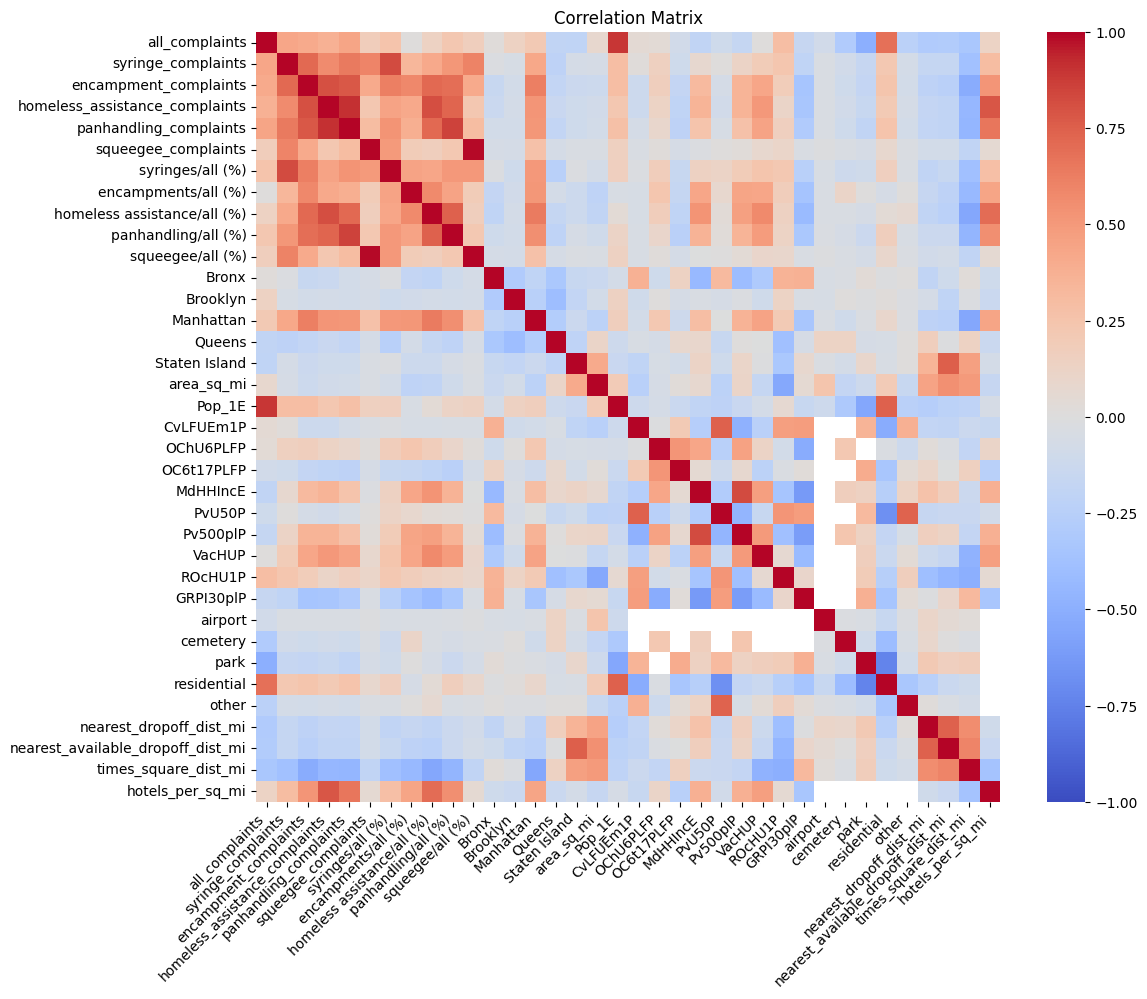

In [65]:
# Visualize the correlation matrix as a heatmap
fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(complaints_by_nta[complaints_by_nta.columns[1:]].corr(), ax = ax, cmap = 'coolwarm', vmin = -1, vmax = 1);
ax.set_title('Correlation Matrix');
ax.set_xticklabels(labels = complaints_by_nta.columns[1:], rotation = 45, ha = 'right');

The heatmap above shows that syringe complaints are most correlated with other categories of 311 complaints, but also slightly correlated with features such as borough, population, residential neighborhoods, distance to Times Square, and the number of hotels per square mile. Again, since many of the features are correlated with one another, I will implement regularization in my model.

## 5.2 Model

In [66]:
# View missing values
complaints_by_nta.isna().sum()

,0
NTA2020,0
all_complaints,0
syringe_complaints,0
encampment_complaints,0
homeless_assistance_complaints,0
panhandling_complaints,0
squeegee_complaints,0
syringes/all (%),0
encampments/all (%),0
homeless assistance/all (%),0


In [67]:
# View the number of NTAs of each NTAType
nta['NTAType'].value_counts()

,count
NTAType,
residential,197
park,40
cemetery,14
other,9
airport,2


In [68]:
# View missing values for residential NTAs only
complaints_by_nta[complaints_by_nta['residential']==1].isna().sum()

,0
NTA2020,0
all_complaints,0
syringe_complaints,0
encampment_complaints,0
homeless_assistance_complaints,0
panhandling_complaints,0
squeegee_complaints,0
syringes/all (%),0
encampments/all (%),0
homeless assistance/all (%),0


The rows missing demographic, economic, and housing data correspond to non-residential neighborhoods, where no one lives and census data is not collected. Since those areas have no residents, it makes sense to set the missing values to zero.

The rows missing hotels data correspond to both residential and non-residential neighborhoods. I'll set the missing values to zero as well since these neighborhoods do not seem to have hotels.

In [69]:
# Set the missing values in complaints_by_nta to zero
complaints_by_nta = complaints_by_nta.fillna(0)

### Linear Regression Model

I'll begin by building a linear regression model to predict syringe complaints. I decided to start with linear regression because it is easy to interpret the results. To prevent overfitting, I will apply regularization using ElasticNet.

In [70]:
# Look at the columns
complaints_by_nta.columns

Index(['NTA2020', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'homeless_assistance_complaints',
       'panhandling_complaints', 'squeegee_complaints', 'syringes/all (%)',
       'encampments/all (%)', 'homeless assistance/all (%)',
       'panhandling/all (%)', 'squeegee/all (%)', 'Bronx', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten Island', 'area_sq_mi', 'Pop_1E',
       'CvLFUEm1P', 'OChU6PLFP', 'OC6t17PLFP', 'MdHHIncE', 'PvU50P',
       'Pv500plP', 'VacHUP', 'ROcHU1P', 'GRPI30plP', 'airport', 'cemetery',
       'park', 'residential', 'other', 'nearest_dropoff_dist_mi',
       'nearest_available_dropoff_dist_mi', 'times_square_dist_mi',
       'hotels_per_sq_mi'],
      dtype='object')

In [71]:
# Choose the X and y variables
X_var_names = ['all_complaints', 'encampment_complaints', 'homeless_assistance_complaints',
               'panhandling_complaints', 'squeegee_complaints', 'area_sq_mi', 'Pop_1E',
               'CvLFUEm1P', 'OChU6PLFP', 'OC6t17PLFP', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P',
               'GRPI30plP', 'nearest_dropoff_dist_mi', 'nearest_available_dropoff_dist_mi',
               'times_square_dist_mi', 'hotels_per_sq_mi', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
               'airport', 'cemetery', 'park', 'residential', 'other']

X = complaints_by_nta[X_var_names]

y = complaints_by_nta[['syringe_complaints']]

# Split the data into train, test, and val sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size = 0.3, random_state = 212)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 212)

In [72]:
# Scale the train, test, and val data based on the train data
X_mean = X_train.mean()
X_std = X_train.std()
X_train_scale = (X_train - X_mean) / X_std
X_test_scale = (X_test - X_mean) / X_std
X_val_scale = (X_val - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std()
y_train_scale = (y_train - y_mean) / y_std
y_test_scale = (y_test - y_mean) / y_std
y_val_scale = (y_val - y_mean) / y_std

In [73]:
# Define a grid of hyperparameters for ElasticNet regularization
# 'alpha' controls overall regularization strength
# 'l1_ratio' balances L1 (Lasso) and L2 (Ridge) regularization
param_grid = {'alpha': np.logspace(-2, 2, 20),
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

# Initialize an ElasticNet regression model
linear_model = ElasticNet(random_state = 212)

# Use grid search to find the best combination of hyperparameters, based on R2
grid_search = GridSearchCV(linear_model, param_grid, cv = 5, scoring = 'r2')

# Fit the model to the training data
grid_search.fit(X_train_scale, y_train_scale)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_linear_model = grid_search.best_estimator_

# Predict on the scaled test set
y_pred_scale = best_linear_model.predict(X_test_scale)

# Unscale the predictions
y_pred = y_pred_scale * y_std.values + y_mean.values

# Print the mean squared error and R2 of the best model
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

# Print the regression coefficients for each predictor variable
for i, coef in enumerate(best_linear_model.coef_):
  print(f'{X_var_names[i]}, coef = {coef}')

Best hyperparameters: {'alpha': np.float64(0.18329807108324356), 'l1_ratio': 0.3}
Mean Squared Error: 48.510351365121345
R2: 0.7515782378275977
all_complaints, coef = 0.10671033344148322
encampment_complaints, coef = 0.30955953570402406
homeless_assistance_complaints, coef = 0.0
panhandling_complaints, coef = 0.16770661747289062
squeegee_complaints, coef = 0.33064850400918633
area_sq_mi, coef = 0.0
Pop_1E, coef = 0.0
CvLFUEm1P, coef = 0.0
OChU6PLFP, coef = 0.0
OC6t17PLFP, coef = 0.0
MdHHIncE, coef = -0.0
PvU50P, coef = 0.0
Pv500plP, coef = -0.0
VacHUP, coef = -0.0
ROcHU1P, coef = 0.0
GRPI30plP, coef = -0.0
nearest_dropoff_dist_mi, coef = -0.0
nearest_available_dropoff_dist_mi, coef = -0.0
times_square_dist_mi, coef = -0.0
hotels_per_sq_mi, coef = 0.0
Bronx, coef = 0.0
Brooklyn, coef = -0.0
Manhattan, coef = 0.0
Queens, coef = -0.011453579850664124
Staten Island, coef = 0.0
airport, coef = -0.0
cemetery, coef = 0.0
park, coef = -0.0
residential, coef = 0.0
other, coef = -0.0


The model's R2 is 0.75 on the test set, meaning that the model explains 75% of the variance in syringe complaints. The features with non-zero coefficients are all_complaints, encampment_complaints, panhandling_complaints, squeegee_complaints, and Queens.

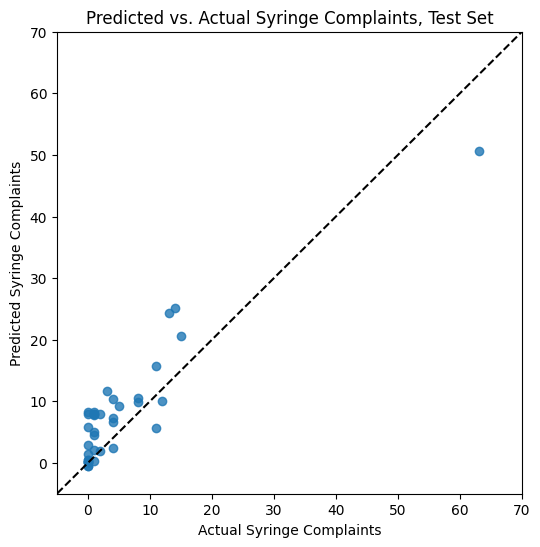

In [74]:
# Plot y_pred vs y_test
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(y_test, y_pred, alpha = 0.8)
ax.plot(np.linspace(-10, 70, 80), np.linspace(-10, 70, 80), 'k--')
ax.set_xlim(-5, 70)
ax.set_ylim(-5, 70)
ax.set_title('Predicted vs. Actual Syringe Complaints, Test Set')
ax.set_xlabel('Actual Syringe Complaints')
ax.set_ylabel('Predicted Syringe Complaints')
plt.show()

The figure above shows the predicted syringe complaints compared to the actual syringe complaints for the test set. The model tends to overestimate the number of syringe complaints.

### Random Forest Model

Next, I'll building a random forest model. I won't scale the features for this model, since random forest models are generally less sensitive to differences in feature magnitude. In addition, unlike the ElasticNet model, where I used GridSearchCV for hyperparameter tuning, I will use RandomizedSearchCV here. This will be more efficient, since a random forest model has more hyperparameters to tune.

In [75]:
# Create a RandomForestRegressor model, using RandomizedSearchCV to optimize the hyperparameters
param_grid = {'n_estimators': randint(100, 500),
              'max_depth': [10, 20, 30, None],
              'max_features': ['sqrt', 'log2', 0.5, 0.8],
              'min_samples_split': randint(2, 10),
              'min_samples_leaf': randint(1, 4)}

# Initialize the model
random_forest = RandomForestRegressor(random_state = 212)

# Use randomized search to find the best combination of hyperparameters, based on R2
random_search = RandomizedSearchCV(random_forest,
                                   param_distributions = param_grid,
                                   n_iter = 30, # number of parameter settings that are sampled
                                   scoring = 'r2',
                                   n_jobs = -1, # use all processors
                                   cv = 5, # 5-fold cross validation
                                   verbose = 2, # control the amount of messages displayed
                                   random_state = 212,  # set a random seed for reproducibility
                                   )

# Fit the model to the training data
random_search.fit(X_train, y_train.values.flatten())

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Get the best model
best_random_forest = random_search.best_estimator_

# Predict on the test set
y_pred = best_random_forest.predict(X_test)

# Print the mean squared error and R2 of the best model
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 161}
Mean Squared Error: 71.72831031417053
R2: 0.6326789490395899


This model is also decent, with an R2 of 0.64 on the test set. However, the mean squared error is higher than that of the elastic net model. This dataset might be too small to train a random forest model.

Since the linear regression model had a higher R2, I will evaluate it a final time using the validation set.

In [76]:
# Evaluate the linear regression model on the validation set
y_pred_scale_val = best_linear_model.predict(X_val_scale)

# Unscale the predictions
y_pred_val = y_pred_scale_val * y_std.values + y_mean.values

# Print the mean squared error and R2 of the best model
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred_val))
print('R2:', metrics.r2_score(y_val, y_pred_val))

Mean Squared Error: 44.55575415388622
R2: 0.34037893106501027


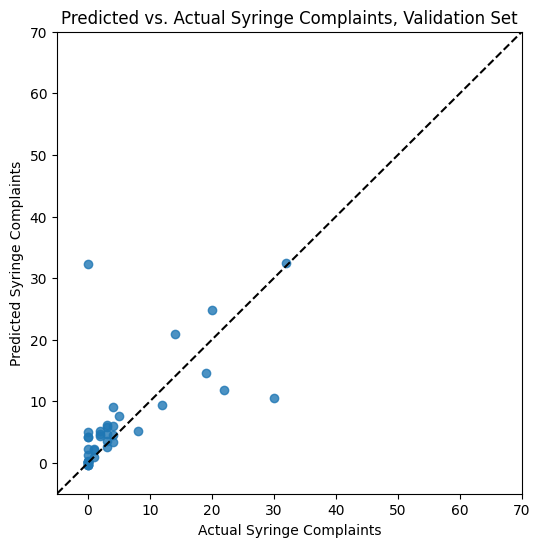

In [77]:
# Plot y_pred_val vs y_val
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(y_val, y_pred_val, alpha = 0.8)
ax.plot(np.linspace(-10, 70, 80), np.linspace(-10, 70, 80), 'k--')
ax.set_xlim(-5, 70)
ax.set_ylim(-5, 70)
ax.set_title('Predicted vs. Actual Syringe Complaints, Validation Set')
ax.set_xlabel('Actual Syringe Complaints')
ax.set_ylabel('Predicted Syringe Complaints')
plt.show()

Interestingly, the R2 on the validation set is much lower than on the test set. As shown in the plot of actual vs. predicted syringe complaints, the validation set contains more values in the middle range, which may have contributed to the lower R2. To illustrate this difference, I will plot the distribution of actual syringe complaint values for both the test and validation sets.

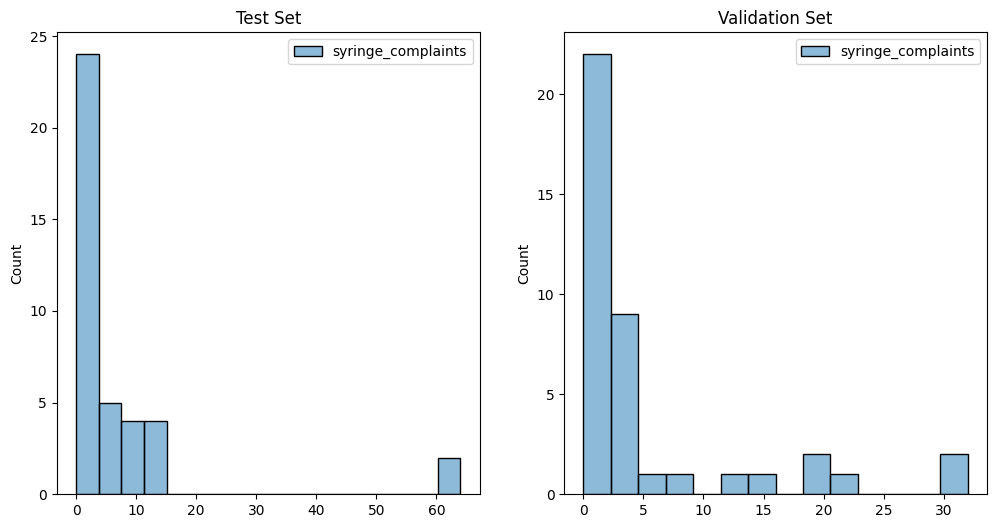

In [78]:
# Make histplots for y_test and y_val side, by side
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.histplot(y_test, ax = axes[0])
sns.histplot(y_val, ax = axes[1])
axes[0].set_title('Test Set')
axes[1].set_title('Validation Set')
plt.show()

# 6 Principal Component Analysis
Finally, I would like to perform principal component analysis on the dataset and visualize the results. This could help identify other underlying patterns in the data.

In [79]:
# Choose the X and y variables
X_var_names = ['all_complaints', 'encampment_complaints', 'homeless_assistance_complaints',
               'panhandling_complaints', 'squeegee_complaints', 'area_sq_mi', 'Pop_1E',
               'CvLFUEm1P', 'OChU6PLFP', 'OC6t17PLFP', 'MdHHIncE', 'PvU50P', 'Pv500plP', 'VacHUP', 'ROcHU1P',
               'GRPI30plP', 'nearest_dropoff_dist_mi', 'nearest_available_dropoff_dist_mi',
               'times_square_dist_mi', 'hotels_per_sq_mi',
               'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
               'airport', 'cemetery', 'park', 'residential', 'other']

X = complaints_by_nta[X_var_names]

# Scale X
X_scaled = (X - X.mean()) / X.std()

In [80]:
# Fit PCA with all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

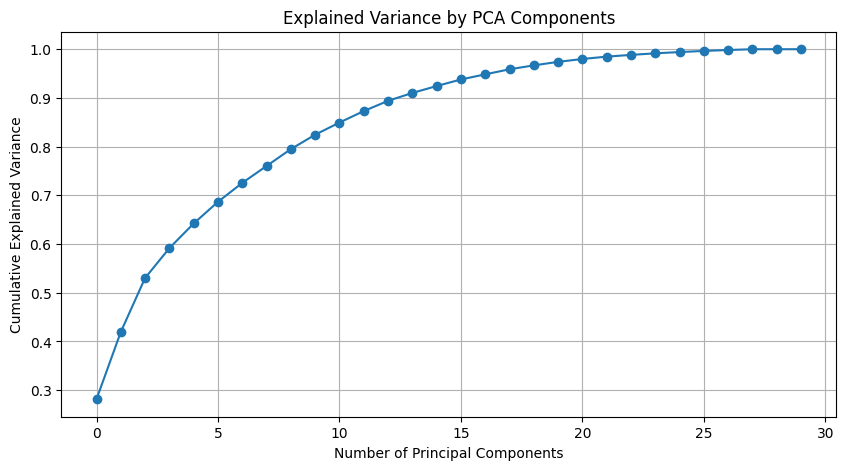

In [81]:
# Plot the cumulative explained variance
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = 'o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

The figure above shows that the first two components account for only about 40% of the variance, and it takes the first 13 components to explain 90% of the variance. Therefore, syringe complaints are influenced by a combination of many different factors.

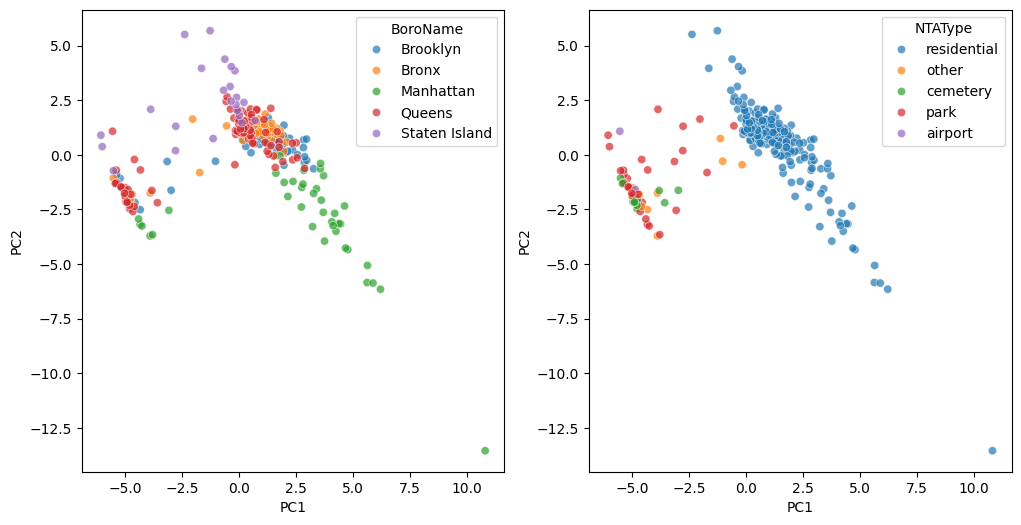

In [82]:
# Plot PC1 vs PC2 on two subplots
# Color one by borough and the other by NTA type
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], alpha = 0.7, ax = axes[0], hue = nta['BoroName'])
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], alpha = 0.7, ax = axes[1], hue = nta['NTAType'])

#Add x label
axes[0].set_xlabel('PC1')
axes[1].set_xlabel('PC1')

#Add y label
axes[0].set_ylabel('PC2')
axes[1].set_ylabel('PC2')

plt.show()

In the figure above, I plotted Principal Component 1 against Principal Component 2, coloring the points by borough and by NTAType. Manhattan shows some separation from the other boroughs, and residential NTAs are distinctly separated from the other NTA types. This matches the finding that both Manhattan and residential NTAs had higher proportions of syringe complaints.

# 7 Ethical Considerations

There are several ethical considerations associated with this project. First, my analysis revealed a correlation between syringe complaints and complaints involving homeless individuals and panhandlers. Since syringe litter carries negative connotations, this finding could contribute to misplaced blame or stigma toward these residents. In addition, highlighting neighborhoods with higher rates of syringe complaints could unintentionally result in increased policing or punitive measures in those communities. Because of these possibilities, it is essential to interpret the results responsibly and with awareness of their effects on others. Furthermore, it is important to stress that a greater number of syringe complaints does not necessarily indicate increased syringe litter, but rather an increase in reporting.


# 8 Conclusions

In this project, I aimed to investigate the factors contributing to syringe-related complaints in New York City. I found that the proportion of syringe complaints follows a seasonal trend, with complaints peaking in summer and declining in winter, perhaps due to changes in outdoor activity and visibility of litter.

I also analyzed the geographic distribution of syringe complaints and found that they are most concentrated in Manhattan, whereas the highest availability of sharps drop-off sites is found in the Bronx and Brooklyn. This implies that establishing more drop-off sites in Manhattan could help reduce the syringe complaints.

Syringe complaints are also correlated with complaints about encampments, panhandling, and squeegeeing (unwanted window-washing for money). These complaint categories had the highest coefficients in the elastic net regression model I built to predict neighborhood-level syringe complaints. However, while the model achieved an R2 of 0.75 on the test set, it only had an R2 of 0.34 on the validation set. This may be due to the validation set having more values in the middle of the range, which the model struggled to predict accurately. Nonetheless, the model provides further evidence that syringe complaints are related to other complaint categories.

Another important finding is that syringe complaints are not strongly negatively correlated with the availability of sharps drop-off sites. One possible explanation is that there are other barriers preventing residents from using drop-off sites. For example, residents are supposed to deliver their sharps in a puncture-resistant container, which may be difficult or impractical (New York City Department of Sanitation, n.d.). Another explanation is that syringe complaints do not reflect the amount of syringe litter but rather residents' attitudes towards it. However, I did not find a strong correlation between syringe complaints and the socioeconomic factors that I included in my analysis. Therefore, more data is needed to understand the patterns in syringe complaints.

There are several approaches I would like to explore in future work. First, I would like to include additional datasets that could help explain the variation in 311 complaints, such as pedestrian foot traffic, proximity to university campuses, or availability of substance abuse treatment centers. Second, I would like to try reframing the analysis as a classification problem rather than a regression problem. One way I could do this is by dividing each neighborhood tabulation area into smaller sections and predicting whether or not a syringe complaint occurs in each one. Finally, I would like to explore a spatial regression model, which would account for the geographic relationships among the neighborhood tabulation areas and complaints. Together, these future approaches may provide further insights into the factors driving syringe complaints in New York City.

# 9 References

City of New York. (n.d.). Squeegee Complaint. NYC 311. https://portal.311.nyc.gov/article/?kanumber=KA-02062

Commonwealth of Massachusetts. (n.d.). How to pick up discarded syringes safely. Mass.gov. https://www.mass.gov/doc/syringe-safety-for-non-healthcare-workers/download

Lunsford, E. (2025, February 18). NYC council member proposes two bills aimed at keeping used needles out of parks. CBS News. Retrieved March 8, 2025, from https://www.cbsnews.com/newyork/news/used-syringes-parks-nyc-bills/

NYC Department of City Planning. (2025, February). Neighborhood Tabulation Areas (NTAs) - Department of City Planning - DCP. NYC.gov. Retrieved May 6, 2025, from https://www.nyc.gov/content/planning/pages/resources/datasets/neighborhood-tabulation

NYC Department of City Planning | Population Division. (2021, 7 21). 2020 Census Reconfiguration of Statistical Geographies. ArcGIS Story Maps. https://storymaps.arcgis.com/stories/d30850ba28944619b94e8ee4f746d5c4

New York City Department of Sanitation. (n.d.). Pharmaceutical & Sharps Drop-Off - DSNY. NYC.gov. Retrieved May 9, 2025, from https://www.nyc.gov/site/dsny/collection/get-rid-of/pharmaceutical-sharps-drop-off.page

U.S. Food & Drug Administration. (2021, November 19). Safely Using Sharps (Needles and Syringes) at Home, at Work and on Travel. FDA. Retrieved May 5, 2025, from https://www.fda.gov/medical-devices/consumer-products/safely-using-sharps-needles-and-syringes-home-work-and-travel